To avoid some errors when using Colab:

In [ ]:
!pip install "torch==1.4" "torchvision==0.5.0"

Update packages:

In [2]:
!curl https://course.fast.ai/setup/colab | bash
from fastai.vision import *

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   322  100   322    0     0   1928      0 --:--:-- --:--:-- --:--:--  1928
Updating fastai...
Done.


Create directory and upload urls file into the server

In [7]:
folder = 'scolopendra'
file = 'urls_scolopendra.csv'

In [12]:
folder = 'scutigera_coleoptrata'
file = 'urls_scutigera_coleoptrata.csv'

In [13]:
path = Path('data/scoscu')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

Now, upload urls files in the working directory.

Then you will need to download your images from their respective urls.

Remember to run code pieces more than once for categorires.

In [10]:
classes = ['scolopendra','scutigera_coleoptrata']

In [ ]:
download_images(path/file, dest, max_pics=200, max_workers=0)

Remove any images that can't be opened:

In [15]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

scolopendra


scutigera_coleoptrata


## View data

In [16]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [ ]:
# If already cleaned the data, run this cell instead of the one before
np.random.seed(42)
data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

Take a look at some of the pictures.

In [17]:
data.classes

['scolopendra', 'scutigera_coleoptrata']

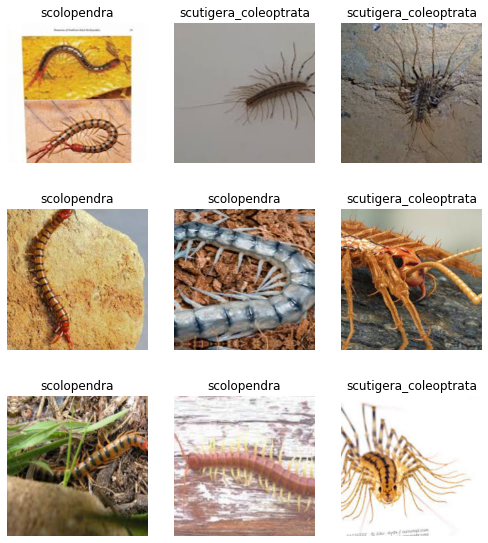

In [20]:
data.show_batch(rows=3, figsize=(7,8))

In [21]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['scolopendra', 'scutigera_coleoptrata'], 2, 320, 80)

## Now train the model.

In [22]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.fit_one_cycle(4)
learn.save('stage-1')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.815389,0.414708,0.137500,00:04
1,0.560924,0.361187,0.087500,00:04
2,0.413205,0.437659,0.087500,00:04
3,0.341869,0.438972,0.075000,00:04


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,error_rate,time
0,0.144942,0.437448,0.062500,00:04
1,0.087130,0.385681,0.075000,00:04


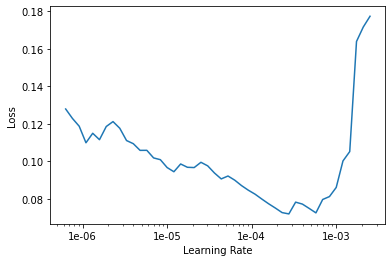

In [23]:
learn.unfreeze()
learn.lr_find()
# If the plot is not showing try to give a start and end learning rate
# learn.lr_find(start_lr=1e-5, end_lr=1e-1)
learn.recorder.plot()
learn.fit_one_cycle(2, max_lr=slice(3e-5,3e-4))
learn.save('stage-2')

## Interpretation

In [ ]:
learn.load('stage-1');

In [24]:
learn.load('stage-2');

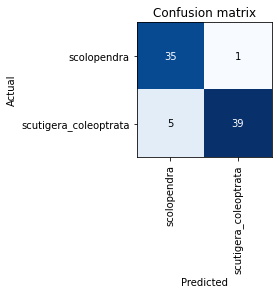

In [25]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

## Cleaning up the data.

In [26]:
from fastai.widgets import *

In [27]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [ ]:
# If you already cleaned your data using indexes from `from_toplosses`,
# run this cell instead of the one before to proceed with removing duplicates.
# Otherwise all the results of the previous step would be overwritten by
# the new run of `ImageCleaner`.

db = (ImageList.from_csv(path, 'cleaned.csv', folder='.')
                   .split_none()
                   .label_from_df()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

Then we create a new learner to use our new databunch with all the images.

In [28]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

In [30]:
learn_cln.load('stage-2');

In [ ]:
learn_cln.load('stage-1');

In [ ]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [32]:
# Don't run this in google colab or any other instances running jupyter lab.
# If you do run this on Jupyter Lab, you need to restart your runtime and
# runtime state including all local variables will be lost.
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [33]:
ds, idxs = DatasetFormatter().from_similars(learn_cln)

Getting activations...


Computing similarities...


In [34]:
ImageCleaner(ds, idxs, path, duplicates=True)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

Recreate the ImageDataBunch from `cleaned.csv` to include the changes we made in the data.

## Putting the model in production

In [35]:
learn.export()

For example:

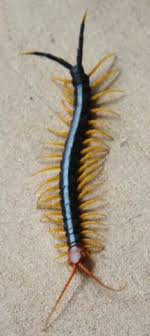

In [36]:
img = open_image(path/'scolopendra'/'00000124.jpg')
img

In [37]:
learn = load_learner(path)

In [38]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class.obj

'scolopendra'